I recognize that I can predict batting average the way Savant does using batted ball data, but I wanted to see if I could train an accurate model
based purely on pitch data and swing path along with some other features (all pre contact) and use that to find batters that will preform well off
specific pitchers. I can then translate that to run production, idk long term goal I suppose

In [2]:

import pandas as pd
import pybaseball
pybaseball.cache.enable()
print(pd.__version__)
from pybaseball import statcast
balldata = statcast(start_dt='2025-01-01',end_dt='2025-07-26')
balldata = pd.DataFrame(balldata)
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

2.3.1
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 134/134 [00:04<00:00, 31.13it/s]
/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [3]:
balldata = pd.DataFrame(balldata)
balldata = balldata[balldata['game_type'] == 'R']
balldata.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2988,SL,2025-07-26,89.6,-1.14,5.82,"Clase, Emmanuel",663697,661403,home_run,hit_into_play,...,0,2.51,-0.64,-0.64,53.4,10.201437,-5.256238,31.190785,36.799437,36.854778
3040,SL,2025-07-26,89.8,-1.24,5.66,"Clase, Emmanuel",663697,661403,None,foul,...,0,2.92,-0.68,-0.68,55.0,12.539365,-9.129701,36.706086,39.485634,32.062794
3151,FC,2025-07-26,99.0,-1.36,5.66,"Clase, Emmanuel",663697,661403,None,called_strike,...,0,1.36,-0.26,-0.26,54.3,<NA>,<NA>,<NA>,<NA>,<NA>
3253,SL,2025-07-26,89.1,-1.38,5.68,"Clase, Emmanuel",663697,661403,None,blocked_ball,...,0,2.49,-0.51,-0.51,48.6,<NA>,<NA>,<NA>,<NA>,<NA>
3369,SL,2025-07-26,88.3,-1.31,5.86,"Clase, Emmanuel",663697,661403,None,called_strike,...,0,2.88,-0.68,-0.68,55.5,<NA>,<NA>,<NA>,<NA>,<NA>


In [4]:
populated_columns = balldata.columns[balldata.notna().any()].tolist()
balldata = balldata[populated_columns]
# Keep only rows where 'des' does NOT contain 'James Wood'
wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
wood = pd.DataFrame(wood)
wood.shape

(3492, 110)

Dropping the columns that don't have anything to do with batting average or are redundant or outdated
This means any variables that occur after the fact, hit type, description etc
Also dropped variables that happen semi randomly throughout the game like runners on base, the score, things that if you
are given an entire season will occur many times. Simulating batting average against a specific pitcher has to encompass all types of game situation, like innings, runners on, outs, stuff like that.

In [5]:
hits = ['single','double','triple','home_run']
lineups_y = balldata['events'].isin(hits).astype(int)
lineups_y.describe()
lineups_x = balldata.drop(columns=['events'])
lineups_x = lineups_x.drop(
    columns=[col for col in lineups_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
lineups_x = lineups_x.drop(columns=[col for col in cols_to_drop if col in lineups_x.columns])
print(lineups_x.shape,lineups_y.shape)
lineups_x.head()

(457466, 67) (457466,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2988,SL,2025-07-26,89.6,-1.14,5.82,663697,661403,5,R,R,...,0,2.51,-0.64,-0.64,53.4,10.201437,-5.256238,31.190785,36.799437,36.854778
3040,SL,2025-07-26,89.8,-1.24,5.66,663697,661403,14,R,R,...,0,2.92,-0.68,-0.68,55.0,12.539365,-9.129701,36.706086,39.485634,32.062794
3151,FC,2025-07-26,99.0,-1.36,5.66,663697,661403,7,R,R,...,0,1.36,-0.26,-0.26,54.3,<NA>,<NA>,<NA>,<NA>,<NA>
3253,SL,2025-07-26,89.1,-1.38,5.68,663697,661403,13,R,R,...,0,2.49,-0.51,-0.51,48.6,<NA>,<NA>,<NA>,<NA>,<NA>
3369,SL,2025-07-26,88.3,-1.31,5.86,663697,661403,14,R,R,...,0,2.88,-0.68,-0.68,55.5,<NA>,<NA>,<NA>,<NA>,<NA>


Split the date column into separate variables for improved accuracy

In [6]:
lineups_x['game_year'] = pd.to_datetime(lineups_x['game_date']).dt.year
lineups_x['game_month'] = pd.to_datetime(lineups_x['game_date']).dt.month
lineups_x['game_day'] = pd.to_datetime(lineups_x['game_date']).dt.day
# Then drop the original datetime column
lineups_x = lineups_x.drop(columns=['game_date','game_day'])


Translated all the categorical columns to strings as to avoid giving too much weight to something like the day (30th) or player ID 8192141 etc

In [7]:
categorical_cols = ['game_year','game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game','zone']
# See which categorical columns are missing from the DataFrame


lineups_x[categorical_cols] = lineups_x[categorical_cols].astype(str)



In [8]:
x_feat_train, x_feat_test, y_feat_train, y_feat_test = tts(lineups_x, lineups_y, test_size = 0.2)
model = CatBoostClassifier(verbose=100)
model.fit(x_feat_train,y_feat_train,cat_features=categorical_cols)

Learning rate set to 0.128093
0:	learn: 0.4561628	total: 148ms	remaining: 2m 27s
100:	learn: 0.1106116	total: 9.23s	remaining: 1m 22s
200:	learn: 0.1003795	total: 19.4s	remaining: 1m 16s
300:	learn: 0.0956581	total: 29.3s	remaining: 1m 8s
400:	learn: 0.0926810	total: 39.6s	remaining: 59.1s
500:	learn: 0.0895280	total: 50.3s	remaining: 50.1s
600:	learn: 0.0873050	total: 1m	remaining: 40.2s
700:	learn: 0.0854660	total: 1m 10s	remaining: 30s
800:	learn: 0.0832115	total: 1m 20s	remaining: 19.9s
900:	learn: 0.0816018	total: 1m 30s	remaining: 9.91s
999:	learn: 0.0801081	total: 1m 39s	remaining: 0us


Next the goal is to find the most important features to predicting batting average

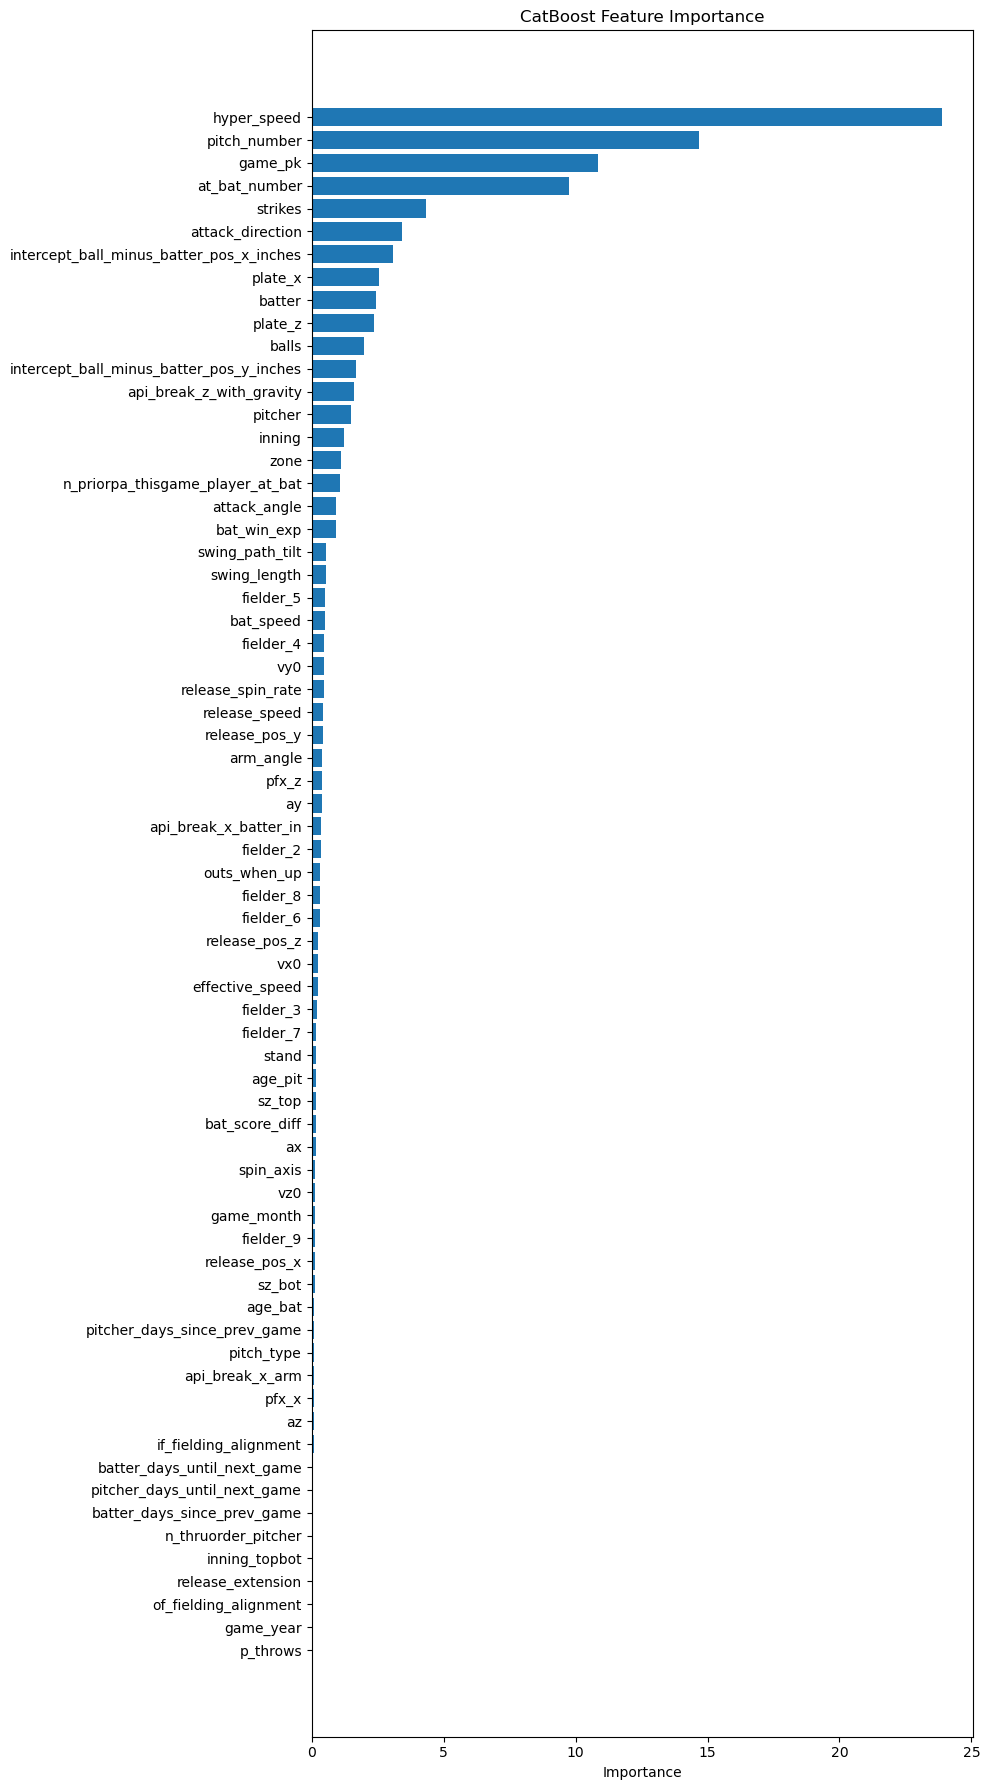

In [9]:
importances = model.get_feature_importance()
features = x_feat_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/sciclone/home/tdfelton/baseball/feature_selection_plots/all_mlb.png')
plt.show()

I can't find anything online to figure out what hyper_speed is but it seems to be important
Pretty sure p_throws effects batting average so I will include it in a more refined data pass, same with stand
of_fielding_alignment probably hsa something to do with BA too...
Not sure if this model was the best choice, going to try to run one on a specific batter.
James Wood is my favorite hitter so I will attempt him next.
Current idea is to cross reference the two feature importances and see what happens, hopefully something that makes more sense than this

In [10]:
james_wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
james_wood = pd.DataFrame(wood)
james_wood.shape

(3492, 110)

In [11]:
hits = ['single','double','triple','home_run']
wood_y = james_wood['events'].isin(hits).astype(int)
wood_x = james_wood.drop(columns=['events'])
wood_x = wood_x.drop(
    columns=[col for col in wood_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp','hyper_speed','batter'
]
wood_x = wood_x.drop(columns=[col for col in cols_to_drop if col in wood_x.columns])
print(wood_x.shape,wood_y.shape)
wood_x.head()

(3492, 65) (3492,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher,zone,stand,p_throws,balls,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3809,SL,2025-07-26,80.5,2.02,6.55,605177,8,R,L,1,...,<NA>,3.73,-0.21,0.21,56.7,18.965816,-30.310194,22.169868,37.912731,49.823888
3999,SL,2025-07-26,81.0,2.03,6.48,605177,14,R,L,0,...,<NA>,3.39,-0.14,0.14,48.5,<NA>,<NA>,<NA>,<NA>,<NA>
4146,SL,2025-07-26,81.0,2.09,6.44,605177,5,R,L,0,...,<NA>,3.31,-0.08,0.08,52.3,16.685318,-45.19746,17.795281,41.923794,56.127397
4281,SI,2025-07-26,89.9,1.7,6.64,605177,5,R,L,0,...,<NA>,1.75,1.14,-1.14,59.1,<NA>,<NA>,<NA>,<NA>,<NA>
1933,ST,2025-07-26,82.4,2.46,5.51,681892,13,L,L,3,...,<NA>,3.52,-1.18,-1.18,29.3,11.740414,0.954266,36.754483,52.402086,31.272104


In [12]:
wood_x['game_year'] = pd.to_datetime(wood_x['game_date']).dt.year
wood_x['game_month'] = pd.to_datetime(wood_x['game_date']).dt.month
wood_x['game_day'] = pd.to_datetime(wood_x['game_date']).dt.day
# Then drop the original datetime column

In [13]:
categorical_cols = ['game_month','pitch_type','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


wood_x[categorical_cols] = wood_x[categorical_cols].astype(str)

In [14]:
x_wood_train, x_wood_test, y_wood_train, y_wood_test = tts(wood_x, wood_y, test_size = 0.2)
wood_model = CatBoostClassifier(verbose=100)
wood_model.fit(x_wood_train,y_wood_train,cat_features=categorical_cols)

Learning rate set to 0.015974
0:	learn: 0.6723755	total: 16.6ms	remaining: 16.6s
100:	learn: 0.2256462	total: 1.2s	remaining: 10.7s


200:	learn: 0.1838662	total: 2.65s	remaining: 10.6s
300:	learn: 0.1555571	total: 4.14s	remaining: 9.61s
400:	learn: 0.1383618	total: 5.56s	remaining: 8.31s
500:	learn: 0.1215393	total: 7.03s	remaining: 7s
600:	learn: 0.1087769	total: 8.51s	remaining: 5.65s
700:	learn: 0.0992347	total: 10s	remaining: 4.28s
800:	learn: 0.0881116	total: 11.5s	remaining: 2.87s
900:	learn: 0.0802699	total: 13s	remaining: 1.43s
999:	learn: 0.0723451	total: 14.5s	remaining: 0us


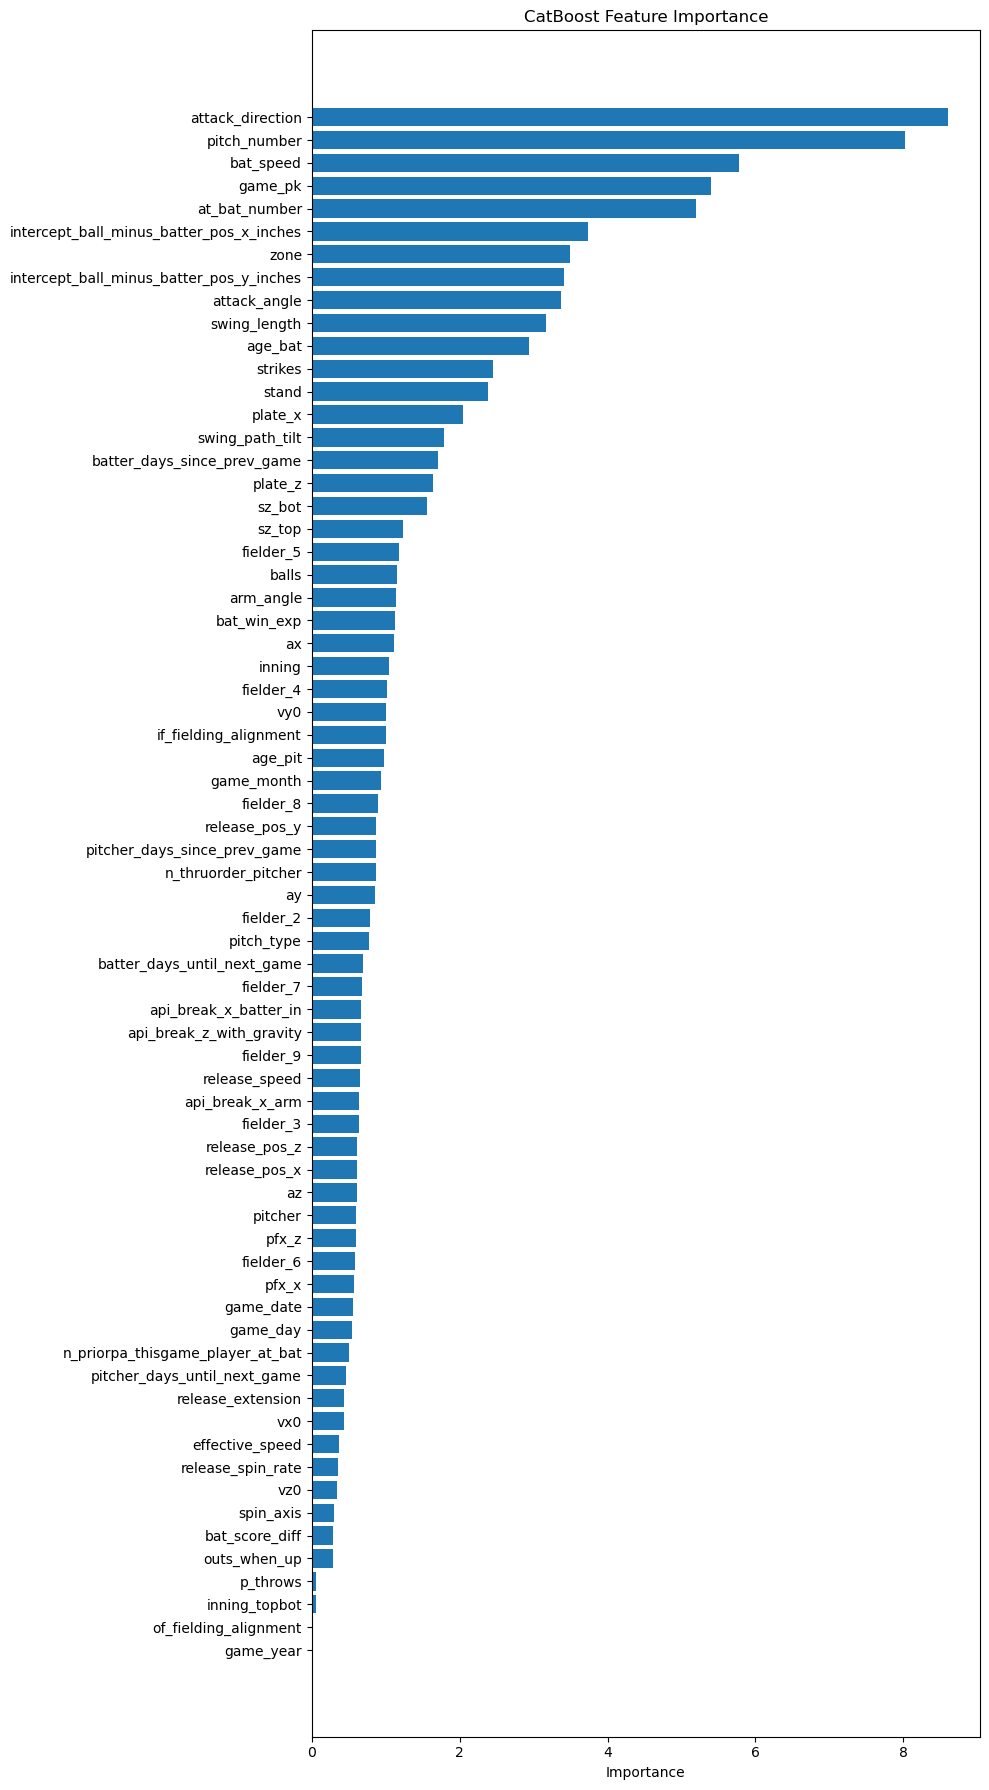

In [15]:
importances = wood_model.get_feature_importance()
features = x_wood_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/sciclone/home/tdfelton/baseball/feature_selection_plots/james_wood.png')
plt.show()

This makes no sense, except.... I still don't know what hyper_speed is! 
Considering dropping it because I think it's results based instead of prepitch/pitch location/ movement etc

I'm going to run this on a few more players with/without hyperspeed and see what the trends are. 

Training the model batter by batter is probably the right approach imo because every hitter has their own unique approach to hitting like swing path speed hotzones etc

New plan: going to make it so I can easily train the model on specific players just by changing one variable input

In [16]:
player = 'Luis García'
player_data = balldata[balldata['des'].astype(str).str.contains(f"{player}", case=False, na=False)]
player_data = pd.DataFrame(player_data)
player_data.shape

(2768, 110)

In [17]:
hits = ['single','double','triple','home_run']
player_y = player_data['events'].isin(hits).astype(int)
player_x = player_data.drop(columns=['events'])
player_x = player_x.drop(
    columns=[col for col in player_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle','hyper_speed',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp','batter',
    'stand','game_pk','bat_speed','swing_length','bat_score_diff','bat_win_exp','attack_angle','attack_direction','swing_path_tilt',
    'age_bat','zone','intercept_ball_minus_batter_pos_x_inches','intercept_ball_minus_batter_pos_y_inches'
]
player_x = player_x.drop(columns=[col for col in cols_to_drop if col in player_x.columns])
print(player_x.shape,player_y.shape)
player_x.head()

(2768, 52) (2768,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher,p_throws,balls,strikes,pfx_x,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
1864,SI,2025-07-26,93.3,2.39,5.63,681892,L,0,0,1.15,...,2,4,23,1,<NA>,<NA>,1.86,1.15,1.15,31.0
3975,CH,2025-07-26,89.5,2.25,5.86,681892,L,1,1,1.27,...,1,3,23,1,<NA>,<NA>,2.45,1.27,-1.27,33.1
4093,FC,2025-07-26,92.7,1.84,5.91,681892,L,1,0,0.03,...,1,3,23,1,<NA>,<NA>,1.6,0.03,-0.03,40.3
4225,FC,2025-07-26,93.1,2.09,5.99,681892,L,0,0,0.29,...,1,3,23,1,<NA>,<NA>,1.54,0.29,-0.29,37.7
4369,FC,2025-07-26,93.2,2.0,5.95,681892,L,1,1,-0.13,...,1,3,23,1,<NA>,<NA>,1.47,-0.13,-0.13,40.8


In [18]:
player_x['game_year'] = pd.to_datetime(player_x['game_date']).dt.year
player_x['game_month'] = pd.to_datetime(player_x['game_date']).dt.month
player_x['game_day'] = pd.to_datetime(player_x['game_date']).dt.day
# Then drop the original datetime column

In [19]:
categorical_cols = ['game_month','pitch_type','pitcher','p_throws',
                    'balls','strikes','inning','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game','inning_topbot']
# See which categorical columns are missing from the DataFrame


player_x[categorical_cols] = player_x[categorical_cols].astype(str)

In [20]:
pd.set_option('display.max_columns', None)
player_x.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher,p_throws,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,inning_topbot,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,if_fielding_alignment,of_fielding_alignment,spin_axis,age_pit,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,game_year,game_month,game_day
1864,SI,2025-07-26,93.3,2.39,5.63,681892,L,0,0,1.15,0.75,0.77,2.63,1,9,Top,-6.837465,-135.728201,-3.694156,15.758316,28.62536,-22.243614,3.45,1.67,95.1,2443,7.2,681508,664034,686797,668904,621043,650489,664056,663616,53.26,74,1,Infield shade,Standard,139,29,2,4,23,1,<NA>,<NA>,1.86,1.15,1.15,31.0,2025,7,26
3975,CH,2025-07-26,89.5,2.25,5.86,681892,L,1,1,1.27,0.38,0.02,3.41,0,8,Top,-8.31882,-130.169072,-0.86257,16.172958,25.83007,-27.846561,3.81,1.81,91.1,1946,7.2,543877,664034,686797,668904,621043,650489,664056,663616,53.31,61,3,Infield shade,Standard,120,29,1,3,23,1,<NA>,<NA>,2.45,1.27,-1.27,33.1,2025,7,26
4093,FC,2025-07-26,92.7,1.84,5.91,681892,L,1,0,0.03,1.03,0.28,1.82,0,8,Top,-4.118717,-135.009876,-7.097998,1.150415,26.143224,-18.331022,3.84,1.9,94.9,2268,7.3,543877,664034,686797,668904,621043,650489,664056,663616,53.22,61,2,Infield shade,Standard,158,29,1,3,23,1,<NA>,<NA>,1.6,0.03,-0.03,40.3,2025,7,26
4225,FC,2025-07-26,93.1,2.09,5.99,681892,L,0,0,0.29,1.05,0.57,4.06,0,8,Top,-4.590215,-135.668787,-1.588646,4.449325,24.975437,-18.974042,3.88,1.91,95.1,2291,7.0,543877,664034,686797,668904,621043,650489,664056,663616,53.49,61,1,Standard,Standard,148,29,1,3,23,1,<NA>,<NA>,1.54,0.29,-0.29,37.7,2025,7,26
4369,FC,2025-07-26,93.2,2.0,5.95,681892,L,1,1,-0.13,1.12,0.33,3.16,0,8,Top,-4.06099,-135.779658,-4.003105,-0.88091,26.391176,-17.563784,3.45,1.67,95.0,2268,7.0,543877,664034,686797,668904,621043,650489,664056,663616,53.5,60,3,Standard,Standard,154,29,1,3,23,1,<NA>,<NA>,1.47,-0.13,-0.13,40.8,2025,7,26


In [21]:
x_play_train, x_play_test, y_play_train, y_play_test = tts(player_x, player_y, test_size = 0.2)
player_model = CatBoostClassifier(verbose=100)
player_model.fit(x_play_train,y_play_train,cat_features=categorical_cols)

Learning rate set to 0.014465
0:	learn: 0.6748558	total: 17.9ms	remaining: 17.9s
100:	learn: 0.2159015	total: 938ms	remaining: 8.35s
200:	learn: 0.1792779	total: 2.15s	remaining: 8.55s
300:	learn: 0.1592699	total: 3.43s	remaining: 7.98s


400:	learn: 0.1409268	total: 4.76s	remaining: 7.12s
500:	learn: 0.1235216	total: 6.11s	remaining: 6.08s
600:	learn: 0.1083064	total: 7.45s	remaining: 4.95s
700:	learn: 0.0961418	total: 8.82s	remaining: 3.76s
800:	learn: 0.0854556	total: 10.2s	remaining: 2.53s
900:	learn: 0.0772525	total: 11.6s	remaining: 1.27s
999:	learn: 0.0700487	total: 12.9s	remaining: 0us


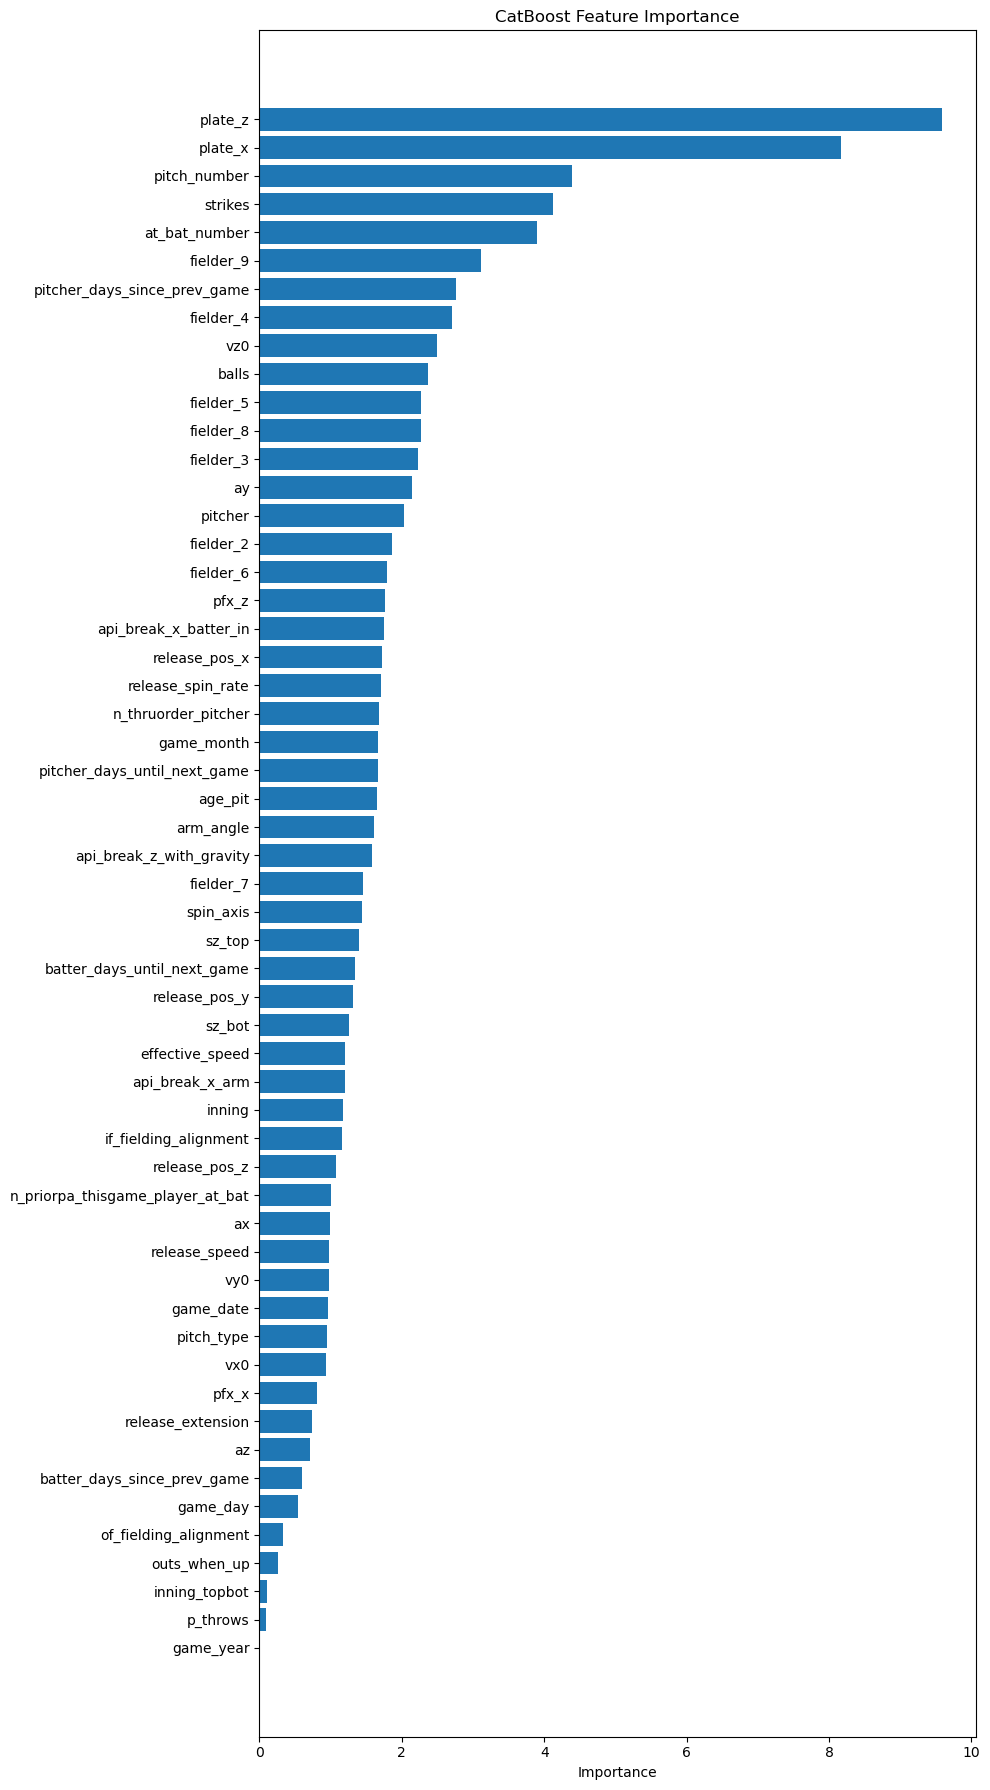

In [22]:
importances = player_model.get_feature_importance()
features = x_play_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'/sciclone/home/tdfelton/baseball/feature_selection_plots/{player.lower().replace(" ","_")}.png')
plt.show()

The hyper_speed variable is too closely related to batting average, this makes me think it is directly calculated using hits or something along those lines without knowing what it is or how it's calculated I cannot ethically use it in my calculations. This may decrease accuracy, but I think it increases the legitamacy of my code.

I have since looked into it, and best I can tell according to Reddit of all places, it seems to be adjusted exit velo.. which is a result based stat. I purely want to build a model that has only binary outcomes (hit/no hit) based on predictive measures so I'm going to cut it out.

Thinking more, I may want to remove hitter specific stats like attack angle/direction because a hitter is going to swing how they're going to swing. I think that if the goal is to predict batter stats against a specific pitcher, we should strictly use pitcher inputs and the result (hit/no hit) as the only batter specific data point.

After digging online, I figured that the intercept_ball_minus yada yada refers to how close the batter is to the ball when he makes contact. I will be removing these 2 columns from the dataframe because I am assuming a batter will stand in the same spot every single time, thus the position of the pitch matters more.

I ran Luis Garcia because I know he has terrible splits against lefties, but p_throws seems to not be an important feature. This leads me to believe the model is misvaluing binary variables. Maybe not giving them enough importance?

I suppose it could also have to do with the fact that getting a hit is a rare occurrence as well as Luis Garcia Jr actually hitting against lefties... so maybe the sample size simply isn't large enough. For the sake of simplicity (as this is my first model) I will choose to accept the output from the model.

In [23]:
# Get importance and features from correct source
importances = player_model.get_feature_importance()
features = player_x.columns  # <-- must match model training input

# Build DataFrame and get top features
imp_df = pd.DataFrame({ "Feature": features, "Importance": importances })
top_features = imp_df.sort_values(by="Importance", ascending=False)["Feature"].head(15).tolist()
cat_top = [col for col in top_features if col in categorical_cols]

# Subset top features and train new model
player_top_full = player_x[top_features]
x_train_new, x_test_new, y_train_new, y_test_new = tts(player_top_full, player_y, test_size=0.2)

new_model = CatBoostClassifier(verbose=100)
new_model.fit(x_train_new, y_train_new, cat_features=cat_top)


Learning rate set to 0.014465
0:	learn: 0.6749485	total: 6.55ms	remaining: 6.54s
100:	learn: 0.2112240	total: 441ms	remaining: 3.93s
200:	learn: 0.1665976	total: 1.1s	remaining: 4.37s
300:	learn: 0.1454104	total: 1.8s	remaining: 4.17s
400:	learn: 0.1305776	total: 2.5s	remaining: 3.73s


500:	learn: 0.1189188	total: 3.19s	remaining: 3.18s
600:	learn: 0.1063775	total: 3.92s	remaining: 2.6s
700:	learn: 0.0939026	total: 4.67s	remaining: 1.99s
800:	learn: 0.0844785	total: 5.42s	remaining: 1.35s
900:	learn: 0.0763844	total: 6.16s	remaining: 677ms
999:	learn: 0.0702312	total: 6.91s	remaining: 0us


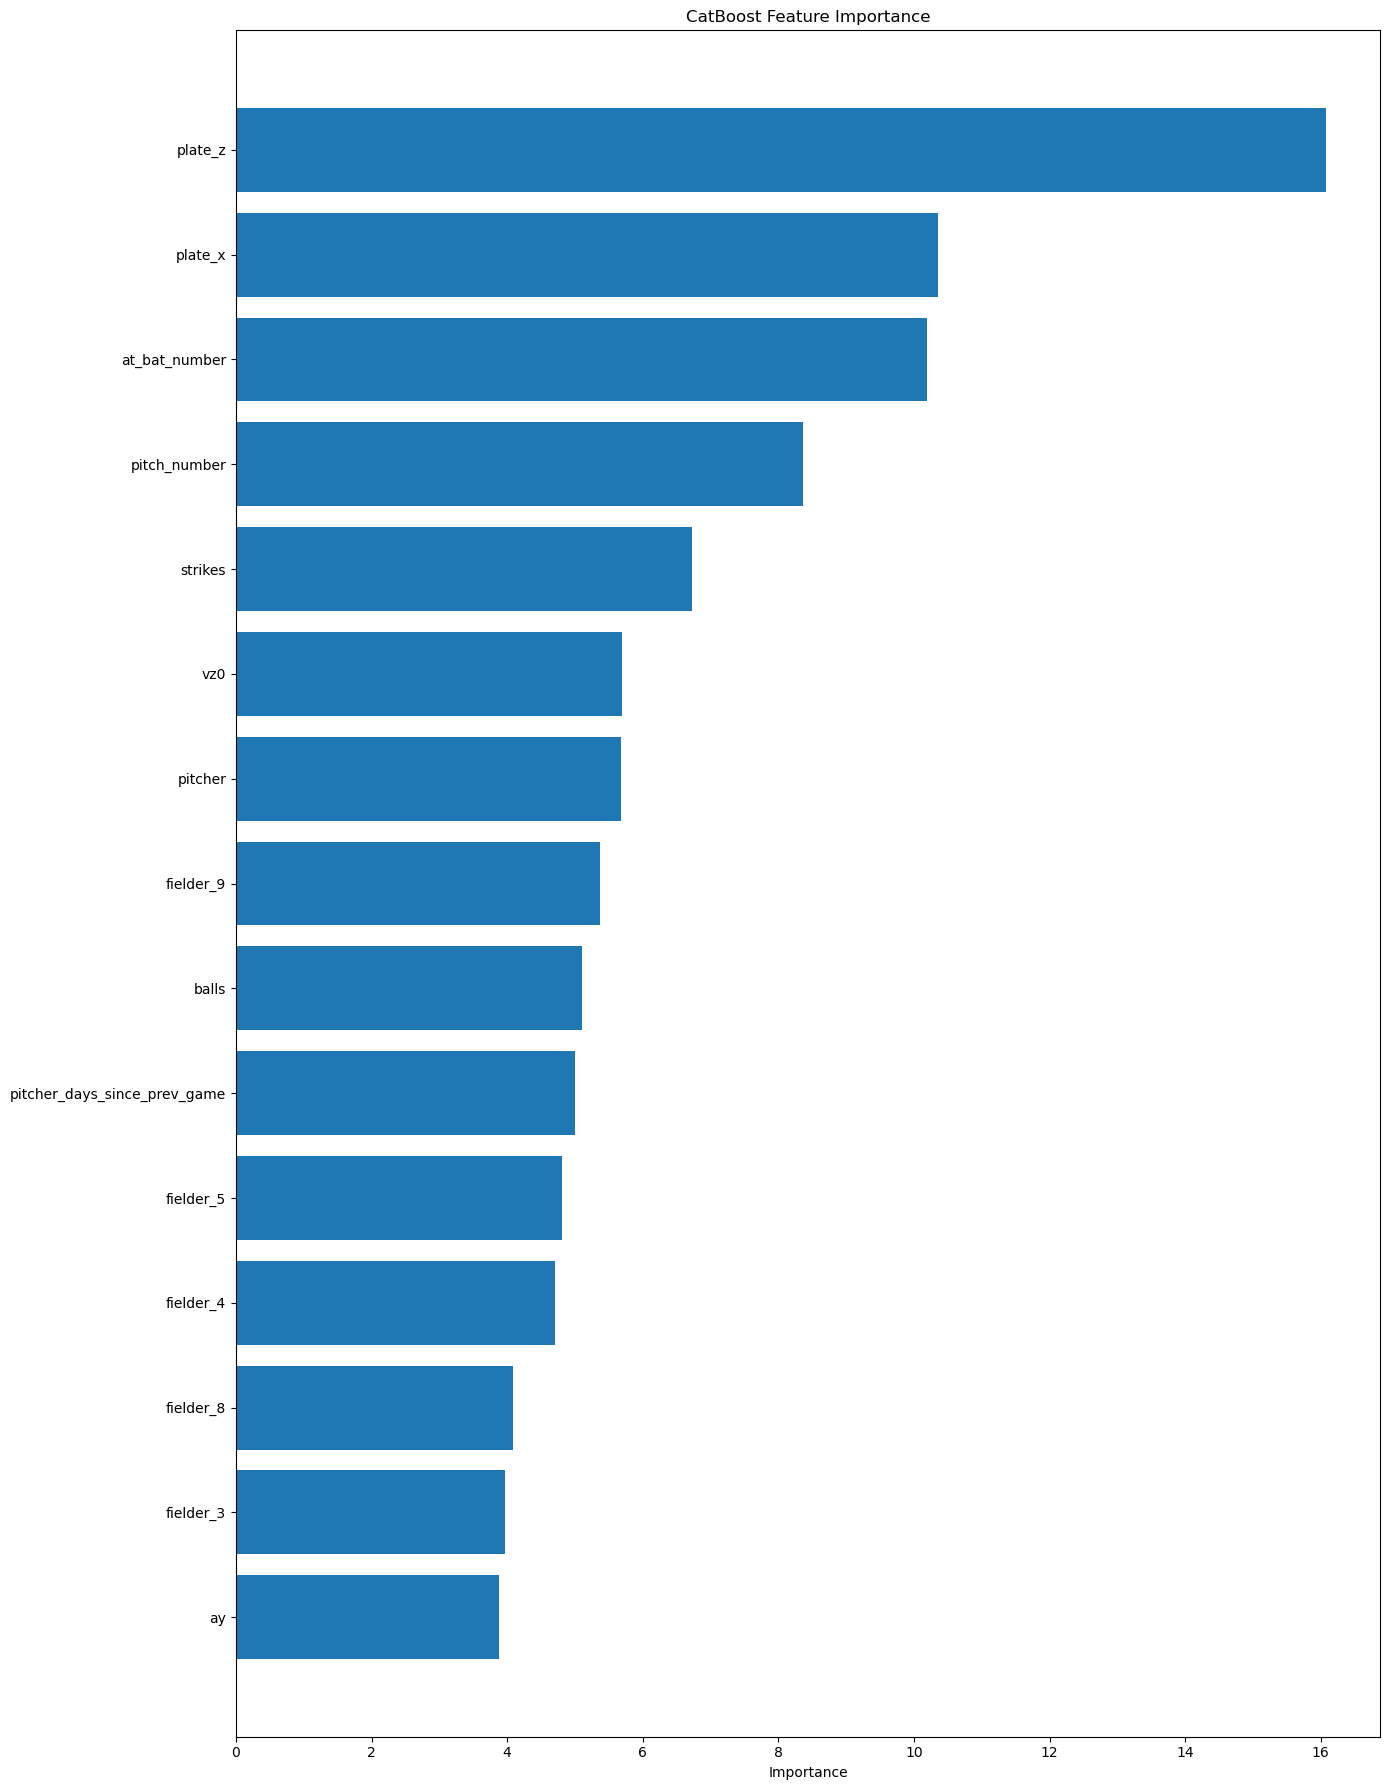

In [24]:
condensed_importances = new_model.get_feature_importance()
features = x_train_new.columns

# Sort and plot
indices = np.argsort(condensed_importances)[::-1]
plt.figure(figsize=(14, 18))
plt.barh(np.array(features)[indices], np.array(condensed_importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'/sciclone/home/tdfelton/baseball/feature_selection_plots/{player.lower().replace(" ","_")}_condensed.png')
plt.show()

This is the first feature importance plot that actually makes sense to me... now going to try and check the accuracy of my model 

Accuracy : 0.9386281588447654
Precision: 0.6666666666666666
Recall   : 0.05714285714285714
F1 Score : 0.10526315789473684


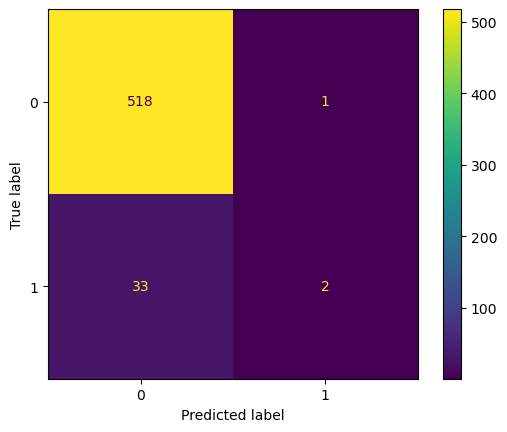

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = new_model.predict(x_test_new)
print("Accuracy :", accuracy_score(y_test_new, y_pred))
print("Precision:", precision_score(y_test_new, y_pred))
print("Recall   :", recall_score(y_test_new, y_pred))
print("F1 Score :", f1_score(y_test_new, y_pred))

cm = confusion_matrix(y_test_new, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Yikes... this is no good. Model didn't predict one hit smh... forgot to account for class imbalance. This means back to the top! Also got a really weird test breakdown with like a 0.060 batting average..?
The second time I ran it, it predicted a whopping 3 hits.

In [ ]:
y_train_new.describe()

count    2214.000000
mean        0.055556
std         0.229113
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: events, dtype: float64

Ok so this tells me that there is something utterly wrong with my dataset, only predicting a .056 batting acerage? Thats awful and I know Garcia is more like .245, possibly just a bad sample... OH... wait no, I know the issue. I'm loading in every pitch, pitches that don't result in an out/hit/walk/error etc are logged as no hit thus making the classes totally imbalanced. This is an interesting issue... Not sure how to address it yet


After doing some research I'm going to attempt something called a 2 stage model. I have never attempted this before and will see where it goes. 